# WeatherPy

*  In the temperature chart below, it illustrates that, generally, places closer to the Equator, approximately -25 to 25 degrees latitude, have relatively higher temperatures than places farther from the Equator.

*  In the humidity chart below, it illustrates that the higher the latitude the more likely the higher the humidity. What does this mean?  I researched it and found that a reading of 100 percent relative humidity means that the air is totally saturated with water vapor and cannot hold any more, creating the possibility of rain.  The chart shows that between 50-75 latitude, % humidity is mostly higher.

*  While the temperatures greatly vary as you move away from the equator, the wind speed stay relatively the same regardless of the distance away from the equator.  Wind speed is about 0 - 20 mph in all latitudes. 




In [1]:
# longtiude (-180 - 180)
# latitude (-90 - 90)

# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests as req
import time
import random
import sys
import math
from citipy import citipy
from datetime import datetime


# flag to run from file created or run from a new generated random numbers
#  True:  to run it from the csv file created
#  False: to create latitude and Longtitude file and call the api

runFromFile = False

outpath = "Resources"
keyfile = 'Keys.py'
latlong_filename = '%s/Locations' % (outpath)
reportDate = datetime.today()
logfilename = "%s/weatherpy_%s" % (outpath, datetime.strftime(reportDate,'%Y%m%d.%f'))


In [2]:
def generate_random_data(radius, num_rows):    
    # longtiude (-180 - 180)
    # latitude (-90 - 90)
    
    counter = 0
    while counter < num_rows:
        lat = float(np.random.randint(-90, 90)) + np.random.randint(-90, 90)/radius
        lon = float(np.random.randint(-180, 180)) + np.random.randint(-180, 180)/radius    

        # find city name
        city = citipy.nearest_city(lat, lon)
        if city.city_name in City:
#             print("Duplicate:  Will Bypass %s" % city.city_name)
            continue
        else:
            counter += 1 
            City.append (city.city_name)
            Lon.append (lon)
            Lat.append (lat)


## Generate City List

In [3]:
if not runFromFile:     
    nbrRows = 700
    # Earths radius
    earthRadius = 3959
    
    City = []
    Lon = []
    Lat = []
    
    print("Creating file: %s.csv" % latlong_filename)
    
    generate_random_data(earthRadius, nbrRows)
    locations_df = pd.DataFrame(
    {'City': City,
     'Lat': Lat,
     'Long': Lon
    }, columns=['City','Lat', 'Long'])

    #  create the city file list 
    locations_df.to_csv("%s.csv" % latlong_filename, index=False)
    locations_df

Creating file: Resources/Locations.csv


## Perform API Calls

In [4]:
if not runFromFile: 
    # Create blank columns for necessary fields
    locations_df["City Id"] = ""
    locations_df["Date"] = ""
    locations_df["Country"] = ""
    locations_df["Max Temp"] = 0
    locations_df["Humidity"] = 0
    locations_df["Cloudiness"] = 0
    locations_df["Wind Speed"] = 0


    # Counters
    row_count = 0
    rowsError = 0
    rowsRetrieved = 0
    
    # get key
    key_pd = pd.read_csv("%s" % (keyfile))
    wkey = key_pd[key_pd['Name']== 'wkey']['key'].max().strip()
#     print(wkey)
    
    fw = open("%s.log" % (logfilename), 'w', newline='\n')

    print("----------------------------------")    
    print("Data Retrieval Start")     
    print("----------------------------------")
    
    fw.write("----------------------------------\n")    
    fw.write("Data Retrieval Start\n")     
    fw.write("----------------------------------\n") 

    # Loop through and grab the lat/lng using Google maps
    for index, row in locations_df.iterrows():    
        # Create endpoint URL
        target_url = "https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=%s&q=%s" % (wkey, row['City'])
    #     print(target_url)
        # Retrieve response in json format
        city_weather = req.get(target_url).json()

        row_count += 1
        try:        
            # Printing log to ensure loop is working correctly
            # get id and name of city
            print("%s Now retrieving city # %s: %s" % (row_count, city_weather['id'], row['City'] ))
            print("%s\n" % target_url)           
            
            fw.write("%s Now retrieving city # %s: %s\n" % (row_count, city_weather['id'], row['City'] ))
            fw.write("%s\n" % target_url)
            
            if (city_weather['cod'] == 200):            
                locations_df.set_value(index,"City Id", city_weather['id'])
                locations_df.set_value(index,"Date", city_weather['dt'])
                locations_df.set_value(index,"Country", city_weather['sys']['country'])
                locations_df.set_value(index,"Max Temp", city_weather['main']['temp'])
                locations_df.set_value(index,"Humidity", city_weather['main']['humidity'])
                locations_df.set_value(index,"Cloudiness", city_weather['clouds']['all'])
                locations_df.set_value(index,"Wind Speed", city_weather['wind']['speed'])
            else:
                locations_df.set_value(index,"City", "*****")
                print("%s ****** Error retrieving city %s - %s " % (row_count, row['City'], city_weather['message']))
                rowsError += 1
                
            rowsRetrieved += 1
            
            if (rowsRetrieved % 100) == 0:
                print("%s: Pausing a few minutes" % time.ctime())
                time.sleep(70)
                print("%s: End pause\n" % time.ctime())                
                
        except:
            print("%s ****** Missing City %s" % (row_count, row['City']))
            rowsError += 1

    print("----------------------------------")    
    print("Data Retrieval Complete")
    print("Total records retrieved: %s" % rowsRetrieved)
    print("Total records in error: %s" % rowsError)
    print("----------------------------------")
    
    fw.write("----------------------------------\n")    
    fw.write("Data Retrieval Complete\n")
    fw.write("Total records retrieved: %s\n" % rowsRetrieved)
    fw.write("Total records in error: %s\n" % rowsError)
    fw.write("----------------------------------\n")
    fw.close()

    #  create the csv that is the one used for this project
    locations_df.to_csv("%s_final.csv" % latlong_filename, index=False)
else:
    # read the random latitude and longtitude
    print("Reading from file: %s_final.csv" % (latlong_filename))
    locations_pd = pd.read_csv("%s_final.csv" % (latlong_filename))
    locations_df = pd.DataFrame(locations_pd)
    
locations_df = locations_df[locations_df['City'] != '****']
locations_df.head()


----------------------------------
Data Retrieval Start
----------------------------------
1 Now retrieving city # 3652764: puerto ayora
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=puerto ayora

2 Now retrieving city # 3443061: chuy
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=chuy

3 Now retrieving city # 1528998: yumen
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=yumen

4 Now retrieving city # 1646443: palabuhanratu
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=palabuhanratu

5 Now retrieving city # 3874787: punta arenas
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=punta arenas

6 Now retrieving city # 3833367: ushuaia
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d1

52 Now retrieving city # 5989520: attawapiskat
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=attawapiskat

53 Now retrieving city # 2015306: tiksi
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=tiksi

54 Now retrieving city # 6165875: three hills
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=three hills

55 Now retrieving city # 2110227: butaritari
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=butaritari

56 Now retrieving city # 1078317: taolanaro
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=taolanaro

57 Now retrieving city # 6174041: victoria
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=victoria

58 Now retrieving city # 2618795: klaksvik
h

104 Now retrieving city # 3181864: bordighera
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=bordighera

105 Now retrieving city # 3393692: itarema
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=itarema

106 Now retrieving city # 539233: kumukh
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=kumukh

107 Now retrieving city # 2122574: ola
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=ola

108 Now retrieving city # 1493756: yuzhno-yeniseyskiy
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=yuzhno-yeniseyskiy

109 Now retrieving city # 2121385: severo-kurilsk
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=severo-kurilsk

110 Now retrieving city # 2654970

157 Now retrieving city # 1636308: manokwari
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=manokwari

158 Now retrieving city # 1798760: pingliang
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=pingliang

159 Now retrieving city # 964432: port alfred
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=port alfred

160 Now retrieving city # 3441273: paso de los toros
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=paso de los toros

161 Now retrieving city # 5530022: san angelo
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=san angelo

162 Now retrieving city # 946973: tzaneen
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=tzaneen

163 Now retrieving city 

208 Now retrieving city # 1688954: san miguel
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=san miguel

209 Now retrieving city # 3424607: tasiilaq
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=tasiilaq

210 Now retrieving city # 2180815: tuatapere
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=tuatapere

211 Now retrieving city # 1489853: tazovskiy
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=tazovskiy

212 Now retrieving city # 3877918: ovalle
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=ovalle

213 Now retrieving city # 1491230: sovetskiy
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=sovetskiy

214 Now retrieving city # 4021858: guerrero ne

261 Now retrieving city # 1213821: sigli
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=sigli

262 Now retrieving city # 964420: port elizabeth
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=port elizabeth

263 Now retrieving city # 1254046: tura
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=tura

264 Now retrieving city # 3932145: pisco
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=pisco

265 Now retrieving city # 778707: mehamn
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=mehamn

266 Now retrieving city # 935214: saint-pierre
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=saint-pierre

267 Now retrieving city # 315468: ergani
https://api.openwe

313 Now retrieving city # 556268: ostrovnoy
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=ostrovnoy

314 Now retrieving city # 1714212: dumabato
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=dumabato

315 Now retrieving city # 1290596: toungoo
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=toungoo

316 Now retrieving city # 5887798: assiniboia
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=assiniboia

317 Now retrieving city # 2014624: udachnyy
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=udachnyy

318 Now retrieving city # 1632694: pangkalanbuun
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=pangkalanbuun

319 Now retrieving city # 2155415: new 

366 Now retrieving city # 1735459: teluk intan
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=teluk intan

367 Now retrieving city # 1729580: bacolod
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=bacolod

368 Now retrieving city # 5017822: bemidji
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=bemidji

369 Now retrieving city # 3393065: parambu
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=parambu

370 Now retrieving city # 2152659: port macquarie
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=port macquarie

371 Now retrieving city # 3386213: touros
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=touros

372 Now retrieving city # 3147104: loding
ht

418 Now retrieving city # 478769: urdoma
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=urdoma

419 Now retrieving city # 1148709: anar darreh
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=anar darreh

420 Now retrieving city # 2063039: port keats
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=port keats

421 Now retrieving city # 1494500: poltavka
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=poltavka

422 Now retrieving city # 1650434: bambanglipuro
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=bambanglipuro

423 Now retrieving city # 4031637: lavrentiya
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=lavrentiya

424 Now retrieving city # 2704613

471 Now retrieving city # 3439189: capitan bado
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=capitan bado

472 Now retrieving city # 533418: lukovetskiy
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=lukovetskiy

473 Now retrieving city # 3422683: kangaatsiaq
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=kangaatsiaq

474 Now retrieving city # 6167817: torbay
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=torbay

475 Now retrieving city # 3838233: salta
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=salta

476 Now retrieving city # 6067472: marystown
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=marystown

477 Now retrieving city # 2303611: axim
h

522 Now retrieving city # 484232: tashla
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=tashla

523 Now retrieving city # 3172172: novi di modena
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=novi di modena

524 Now retrieving city # 2980080: saint-francois
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=saint-francois

525 Now retrieving city # 3868626: valparaiso
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=valparaiso

526 Now retrieving city # 2020584: magistralnyy
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=magistralnyy

527 Now retrieving city # 4109785: el dorado
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=el dorado

528 Now retrieving 

573 Now retrieving city # 3377301: mabaruma
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=mabaruma

574 Now retrieving city # 1513491: komsomolskiy
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=komsomolskiy

575 Now retrieving city # 1688781: san pedro
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=san pedro

576 Now retrieving city # 3457817: marau
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=marau

577 Now retrieving city # 6063191: mackenzie
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=mackenzie

578 Now retrieving city # 3113840: santa eulalia del rio
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=santa eulalia del rio

579 Now retrieving c

625 Now retrieving city # 1062663: mahajanga
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=mahajanga

626 Now retrieving city # 2184707: wanaka
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=wanaka

627 Now retrieving city # 2137773: vao
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=vao

628 Now retrieving city # 543737: karaul
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=karaul

629 Now retrieving city # 543508: kovdor
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=kovdor

630 Now retrieving city # 3572462: dunmore town
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=dunmore town

631 Now retrieving city # 3515431: tlalnepantla
https://api.openwe

678 Now retrieving city # 314967: fethiye
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=fethiye

679 Now retrieving city # 1271912: fatehpur
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=fatehpur

680 Now retrieving city # 1253392: varkkallai
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=varkkallai

681 Now retrieving city # 1625929: sungaipenuh
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=sungaipenuh

682 Now retrieving city # 1816751: beidao
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=beidao

683 Now retrieving city # 3521108: progreso
https://api.openweathermap.org/data/2.5/weather?units=imperial&appid=77004d160b3009ad5c5fef5b50e2c32e&q=progreso

684 Now retrieving city # 1214488: meulaboh
https

,City,Lat,Long,City Id,Date,Country,Max Temp,Humidity,Cloudiness,Wind Speed
0,puerto ayora,-25.003536,-105.034100,3652764,1505322000,EC,73,69,75,18
1,chuy,-51.007325,-32.998990,3443061,1505327289,UY,57,100,100,13
2,yumen,37.019197,93.018439,1528998,1505327289,CN,54,56,0,6
3,palabuhanratu,-18.991665,96.992675,1646443,1505327289,ID,77,100,12,17
4,punta arenas,-73.996969,-113.014398,3874787,1505325600,CL,37,55,75,33


In [5]:
locations_df.count()

City          700
Lat           700
Long          700
City Id       700
Date          700
Country       700
Max Temp      700
Humidity      700
Cloudiness    700
Wind Speed    700
dtype: int64

## Latitude vs Temperature Plot

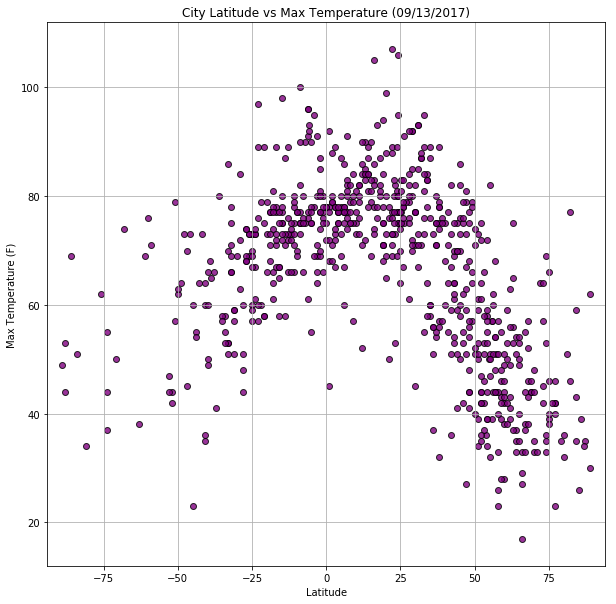

In [6]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(locations_df['Lat'],locations_df['Max Temp'], marker="o", color="purple", alpha=0.8, edgecolors="black", linewidth=1) 

ax.grid(True)
ax.set_title('City Latitude vs Max Temperature (%s)' % datetime.strftime(reportDate,'%m/%d/%Y'))
ax.set_xlabel('Latitude')
ax.set_ylabel('Max Temperature (F)')
ax.set_xlim(locations_df['Lat'].min()-5, locations_df['Lat'].max()+5)
ax.set_ylim(locations_df['Max Temp'].min()-5, (locations_df['Max Temp'].max()+5))
plt.show()

## Latitude vs Humidity Plot

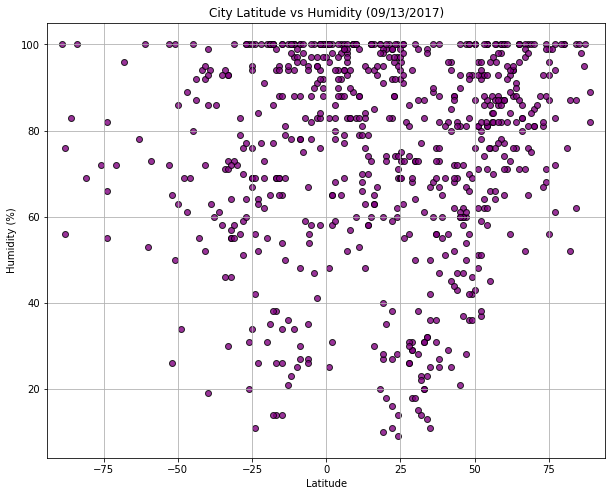

In [7]:
plt.figure(figsize=(10,8))
plt.scatter(locations_df['Lat'],locations_df['Humidity'], marker="o", color="purple", alpha=0.8, edgecolors="black", linewidth=1) 

plt.grid(True)
plt.title('City Latitude vs Humidity (%s)' % datetime.strftime(reportDate,'%m/%d/%Y'))
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.xlim(locations_df['Lat'].min()-5, locations_df['Lat'].max()+5)
plt.ylim(locations_df['Humidity'].min()-5, (locations_df['Humidity'].max()+5))
plt.show()

## Latitude vs Cloudiness Plot

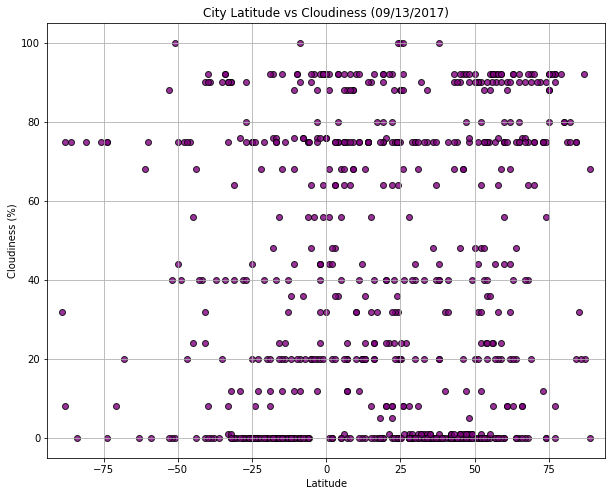

In [8]:
plt.figure(figsize=(10,8))
plt.scatter(locations_df['Lat'],locations_df['Cloudiness'], marker="o", color="purple", alpha=0.8, edgecolors="black", linewidth=1) 

plt.grid(True)
plt.title('City Latitude vs Cloudiness (%s)' % datetime.strftime(reportDate,'%m/%d/%Y'))
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.xlim(locations_df['Lat'].min()-5, locations_df['Lat'].max()+5)
plt.ylim(locations_df['Cloudiness'].min()-5, (locations_df['Cloudiness'].max()+5))
plt.show()

## Latitude vs Wind Speed Plot

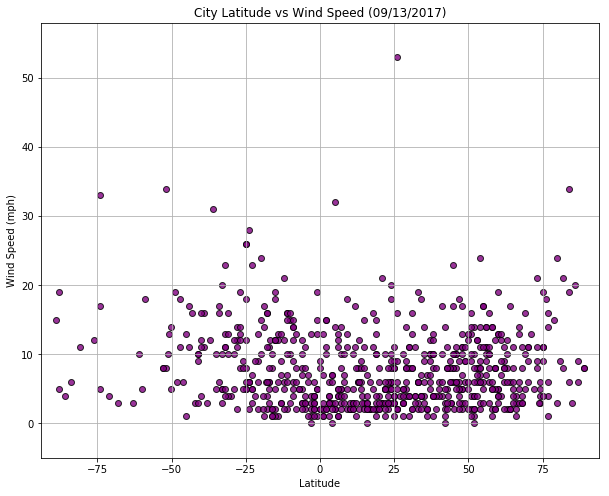

In [9]:
plt.figure(figsize=(10,8))
plt.scatter(locations_df['Lat'],locations_df['Wind Speed'], marker="o", color="purple", alpha=0.8, edgecolors="black", linewidth=1) 

plt.grid(True)
plt.title('City Latitude vs Wind Speed (%s)' % datetime.strftime(reportDate,'%m/%d/%Y'))
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.xlim(locations_df['Lat'].min()-5, locations_df['Lat'].max()+5)
plt.ylim(locations_df['Wind Speed'].min()-5, (locations_df['Wind Speed'].max()+5))
plt.show()